In [31]:
%matplotlib inline

In [2]:
import tensorflow as tf
from tensorflow import keras
import pandas as pd
from pathlib import Path

In [40]:
# Constrant values
NUM_PARALLEL = 1
BATCH_SIZE = 32

In [3]:
base_path = Path('./inputs/google-landmark/')
train_csv_path = base_path / 'train.csv'

print('base_path:', base_path)
print('train_data', train_csv_path)

base_path: inputs\google-landmark
train_data inputs\google-landmark\train.csv


In [4]:
train_df = pd.read_csv(train_csv_path)
train_df.head()

,id,url,landmark_id
0,6e158a47eb2ca3f6,https://upload.wikimedia.org/wikipedia/commons...,142820
1,202cd79556f30760,http://upload.wikimedia.org/wikipedia/commons/...,104169
2,3ad87684c99c06e1,http://upload.wikimedia.org/wikipedia/commons/...,37914
3,e7f70e9c61e66af3,https://upload.wikimedia.org/wikipedia/commons...,102140
4,4072182eddd0100e,https://upload.wikimedia.org/wikipedia/commons...,2474


In [5]:
train_df = train_df.sort_values(by=['id'])
train_df.head()

,id,url,landmark_id
1009792,0000059611c7d079,http://upload.wikimedia.org/wikipedia/commons/...,107382
3587782,0000070506c174cc,http://upload.wikimedia.org/wikipedia/commons/...,149519
1892433,000008ae30de967e,https://upload.wikimedia.org/wikipedia/commons...,161327
2484033,000014b1f770f640,http://upload.wikimedia.org/wikipedia/commons/...,15430
3738173,000015f76534add3,https://upload.wikimedia.org/wikipedia/commons...,158262


In [47]:
label_size = train_df['landmark_id'].max()

In [10]:
# get file_list and label list
file_list = []
label_list = []

for index in range(train_df.shape[0]):
    row = train_df.iloc[index]
    each_id = row['id']
    each_label = row['landmark_id']
    each_path = str(base_path / each_id[0] / each_id[1] / each_id[2] / (each_id + '.jpg'))
    file_list.append(each_path)
    label_list.append(each_label)
    
    # unomment following lines when train full dataset
    if index > 100:
        break
        
print(file_list[:5])
print(label_list[:5])

['inputs\\google-landmark\\0\\0\\0\\0000059611c7d079.jpg', 'inputs\\google-landmark\\0\\0\\0\\0000070506c174cc.jpg', 'inputs\\google-landmark\\0\\0\\0\\000008ae30de967e.jpg', 'inputs\\google-landmark\\0\\0\\0\\000014b1f770f640.jpg', 'inputs\\google-landmark\\0\\0\\0\\000015f76534add3.jpg']
[107382, 149519, 161327, 15430, 158262]


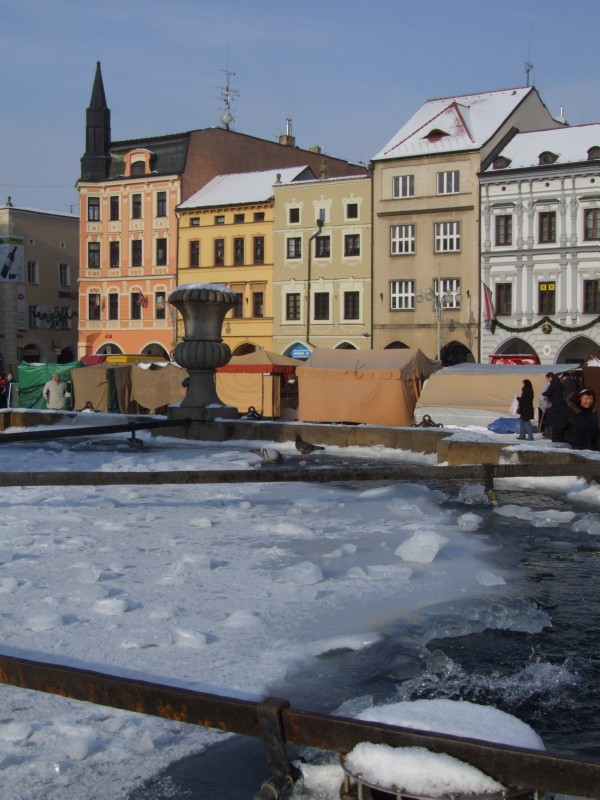

In [11]:
# make sure the image path is correct
import IPython.display as display
display.display(display.Image(file_list[0]))

In [14]:
# build up tensorflow dataset
path_ds = tf.data.Dataset.from_tensor_slices(file_list)
label_ds = tf.data.Dataset.from_tensor_slices(label_list)
print(image_ds)
print(label_ds)

<TensorSliceDataset shapes: (), types: tf.string>
<TensorSliceDataset shapes: (), types: tf.int32>


In [28]:
def load_and_preprocess_image(path):
    img_raw = tf.io.read_file(path)
    image = tf.image.decode_jpeg(img_raw, channels=3)
    image = tf.image.resize(image, [192, 192])
    image /= 250
  
    return image
    
# test function
img_tensor = load_and_preprocess_image(file_list[0])
print(img_tensor.shape)
print(img_tensor.numpy().min())
print(img_tensor.numpy().max())

(192, 192, 3)
0.0045001833
0.8848955


In [29]:
image_ds = path_ds.map(load_and_preprocess_image)
print(image_ds)

<MapDataset shapes: (192, 192, 3), types: tf.float32>


W0518 14:24:07.573518  7276 image.py:648] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
W0518 14:24:07.602416  7276 image.py:648] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


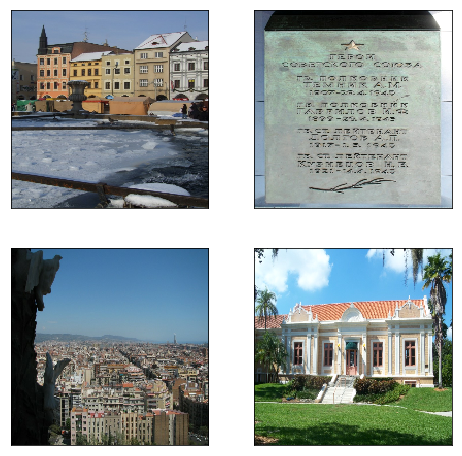

In [32]:
# Show reprocessed image dataset items
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 8))
for n, image in enumerate(image_ds.take(4)):
    plt.subplot(2, 2, n+1)
    plt.imshow(image)
    plt.grid(False)
    plt.xticks([])
    plt.yticks([])

In [33]:
label_ds = tf.data.Dataset.from_tensor_slices(tf.cast(label_list, tf.int64))
label_ds

<TensorSliceDataset shapes: (), types: tf.int64>

In [34]:
image_label_ds = tf.data.Dataset.zip((image_ds, label_ds))
image_label_ds

<ZipDataset shapes: ((192, 192, 3), ()), types: (tf.float32, tf.int64)>

In [36]:
for image, label in image_label_ds.take(3):
    print(image)
    print(label)

tf.Tensor(
[[[0.45366666 0.55766666 0.6976667 ]
  [0.456      0.56       0.7       ]
  [0.46275    0.55875    0.70275   ]
  ...
  [0.42170835 0.536      0.69210416]
  [0.42233333 0.5376667  0.692     ]
  [0.42466664 0.54       0.6943333 ]]

 [[0.4489375  0.5529375  0.7009375 ]
  [0.448      0.552      0.698     ]
  [0.448625   0.552      0.6923125 ]
  ...
  [0.430875   0.5366875  0.696     ]
  [0.434      0.537      0.696     ]
  [0.434      0.537      0.696     ]]

 [[0.4356875  0.5476875  0.6956875 ]
  [0.44066668 0.552      0.7       ]
  [0.44810414 0.5521042  0.6998958 ]
  ...
  [0.42697915 0.5382917  0.6957708 ]
  [0.42833334 0.5393333  0.6956667 ]
  [0.42833334 0.5393333  0.6956667 ]]

 ...

 [[0.49693725 0.53693724 0.58443725]
  [0.5021873  0.54218733 0.5821873 ]
  [0.5035629  0.54356295 0.5795629 ]
  ...
  [0.11583307 0.11116657 0.09095828]
  [0.14993727 0.14527076 0.12527077]
  [0.13410383 0.12943733 0.10943733]]

 [[0.473375   0.513375   0.560875  ]
  [0.5089375  0.5489375  0

In [37]:
mobile_net = keras.applications.MobileNetV2(input_shape=(192, 192, 3), include_top=False)
mobile_net.trainable = False

9412608/9406464 [==============================] - 25s 3us/step


In [41]:
ds = image_label_ds.shuffle(buffer_size=len(file_list))
ds = ds.repeat()
ds = ds.batch(BATCH_SIZE)
ds = ds.prefetch(buffer_size=NUM_PARALLEL)
ds

<PrefetchDataset shapes: ((None, 192, 192, 3), (None,)), types: (tf.float32, tf.int64)>

In [42]:
# Since the mobile net model convert the input from a range of [0, 1] to [-1, 1]
def change_range(image, label):
    return 2*image - 1, label

keras_ds = ds.map(change_range)

In [43]:
image_batch, label_batch = next(iter(keras_ds))

In [44]:
feature_map_batch = mobile_net(image_batch)
print(feature_map_batch.shape)

(32, 6, 6, 1280)


## use tranfer learning to train the model

In [48]:
# define the model
model = keras.Sequential([
    mobile_net,
    keras.layers.GlobalAvgPool2D(),
    keras.layers.Dense(label_size)
])

In [49]:
logit_batch = model(image_batch).numpy()

print('min logit', logit_batch.min())
print('max logit', logit_batch.max())

min logit -0.49394274
max logit 0.48572737


In [50]:
model.compile(optimizer=keras.optimizers.Adam(),
              loss='sparse_categorical_crossentropy',
              metrics=["accuracy"])

In [51]:
len(model.trainable_variables)

2

In [52]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenetv2_1.00_192 (Model) (None, 6, 6, 1280)        2257984   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1280)              0         
_________________________________________________________________
dense (Dense)                (None, 203093)            260162133 
Total params: 262,420,117
Trainable params: 260,162,133
Non-trainable params: 2,257,984
_________________________________________________________________


In [53]:
model.fit(ds, epochs=1, steps_per_epoch=3)

3/3 [==============================] - 4s 1s/step - loss: 17.4231 - accuracy: 0.0000e+00
